In [1]:
pip install cirq openfermion openfermionpyscf qiskit qiskit-nature pyscf

In [2]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from typing import Iterator, Dict, Tuple, List, Callable, Optional, Sequence, Union

from pyscf import gto, scf, ao2mo, mcscf

import cirq
from openfermion import FermionOperator, jordan_wigner, get_sparse_operator
from scipy.sparse import csr_matrix
import scipy.linalg

from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.operators import ElectronicIntegrals
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import JordanWignerMapper


In [3]:
# @title
# Fourier spike utilities
def delta_series_step_period_2L(L: float, K: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Unwindowed delta-series in frequency for the period-2L step: 1 on [-L,0], 0 on (0,L].
    Returns svals=ω_k and cvals=F_k for k=-K..K under g(s)=(1/2π)∫F(ω)e^{iω s}dω."""
    ks = np.arange(-K, K + 1, dtype=int)
    omega = (ks * np.pi) / L
    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = np.pi
        elif k % 2 != 0:
            F[i] = 2j / k
        else:
            F[i] = 0.0
    return omega, F, ks


def apply_window(ks: np.ndarray, F: np.ndarray, kind: str | None = "lanczos", p: int = 1) -> np.ndarray:
    """Apply a harmonic taper to reduce Gibbs. Modifies amplitudes F_k -> w_k * F_k."""
    K = (len(ks) - 1) // 2
    if not kind:
        return F
    w = np.ones_like(F, dtype=float)
    if kind.lower().startswith("lanczos"):
        w = np.sinc(ks / (K + 1)) ** p
    elif kind.lower().startswith("fejer"):
        w = 1.0 - np.abs(ks) / (K + 1)
        w[w < 0] = 0.0
    return w * F


def reconstruct_from_spikes(s: np.ndarray, L: float, ks: np.ndarray, F: np.ndarray) -> np.ndarray:
    """g(s) ≈ (1/2π) * Σ_k F_k e^{i (kπ/L) s)."""
    s = np.asarray(s, float)
    omega = (ks * np.pi) / L
    series = np.zeros_like(s, dtype=complex)
    for ok, Fk in zip(omega, F):
        series += Fk * np.exp(1j * ok * s)
    return (series / (2.0 * np.pi)).real


def step_spikes_period_2L(L: float, K: int, A: float = 1.0, window: str | None = "lanczos", p: int = 1, drop_zeros: bool = True, eps: float = 1e-15) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (svals, cvals) for the 2L-periodic step."""
    ks = np.arange(-K, K + 1, dtype=int)
    omega = (ks * np.pi) / L
    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = A * np.pi
        elif k % 2 != 0:
            F[i] = (2j * A) / k
        else:
            F[i] = 0.0
    if window:
        Kmax = (len(ks) - 1) // 2
        if window.lower().startswith("lanczos"):
            w = np.sinc(ks / (Kmax + 1)) ** p
        elif window.lower().startswith("fejer"):
            w = 1.0 - np.abs(ks) / (Kmax + 1)
            w[w < 0] = 0.0
        else:
            w = np.ones_like(ks, dtype=float)
        F = w * F
    if drop_zeros:
        keep = np.abs(F) > eps
        ks, omega, F = ks[keep], omega[keep], F[keep]
    svals = omega
    cvals = F
    return svals, cvals, ks


def fourier_function_factory(ck: np.ndarray, wk: np.ndarray, phik: Optional[np.ndarray]) -> Callable[[np.ndarray], np.ndarray]:
    """Build f(x) = sum_k c_k * exp(i*(wk*x + phik))."""
    ck = np.asarray(ck, dtype=complex)
    wk = np.asarray(wk, dtype=float)
    if phik is None:
        phik = np.zeros_like(wk, dtype=float)
    else:
        phik = np.asarray(phik, dtype=float)
    assert ck.shape == wk.shape == phik.shape
    def f(x: Union[float, np.ndarray]) -> np.ndarray:
        x = np.asarray(x, dtype=float)[..., None]
        phase = wk[None, :] * x + phik[None, :]
        return np.sum(ck[None, :] * np.exp(1j * phase), axis=-1) / (2.0 * np.pi)
    return f


In [4]:
# @title
# Subspace utilities
def basis_fixed_N(n_sites: int, N: int, dtype=np.uint64) -> np.ndarray:
    """Generate all bitstrings (as integers) with Hamming weight N on n_sites orbitals."""
    if not (0 <= N <= n_sites):
        raise ValueError("N must be in [0, n_sites].")
    dets = []
    for occ in combinations(range(n_sites), N):
        x = 0
        for i in occ:
            x |= (1 << i)
        dets.append(x)
    return np.array(dets, dtype=dtype)


def basis_fixed_N_iter(n_sites: int, N: int) -> Iterator[int]:
    """Memory-light iterator version of basis_fixed_N."""
    if not (0 <= N <= n_sites):
        raise ValueError("N must be in [0, n_sites].")
    for occ in combinations(range(n_sites), N):
        x = 0
        for i in occ:
            x |= (1 << i)
        yield x


def index_map(basis: np.ndarray) -> Dict[int, int]:
    """Map a bitstring (as int) to its row/col index in the basis."""
    return {int(x): k for k, x in enumerate(basis)}


def basis_alpha_beta(L: int, Na: int, Nb: int) -> np.ndarray:
    """Enumerate FCI determinants with separate α and β particle numbers."""
    if Na > (L + 1) // 2 or Nb > L // 2:
        raise ValueError("More particles than available spin-orbitals")
    alpha_sites = range(0, L, 2)
    beta_sites  = range(1, L, 2)
    dets = []
    for alpha_occ in combinations(alpha_sites, Na):
        for beta_occ in combinations(beta_sites, Nb):
            state = 0
            for i in alpha_occ:
                state |= 1 << i
            for j in beta_occ:
                state |= 1 << j
            dets.append(state)
    dets.sort()
    return np.array(dets, dtype=np.uint32)


def restrict_to_subspace(mat_full: Union[np.ndarray, csr_matrix], basis: Sequence[int]) -> np.ndarray:
    """Project a full Hamiltonian into the subspace spanned by `basis`."""
    if isinstance(basis, np.ndarray):
        if hasattr(mat_full, 'tocsr'):
            return mat_full[basis, :][:, basis].toarray()
        else:
            return mat_full[np.ix_(basis, basis)]
    else:
        return mat_full


In [5]:
# @title
# Hamiltonian utilities
def pyscf_to_spatial_integrals(mol: gto.Mole, mf: scf.RHF) -> tuple[float, np.ndarray, np.ndarray]:
    """Transform one- and two-electron integrals into the MO basis."""
    C = mf.mo_coeff
    nmo = C.shape[1]
    h1 = np.dot(np.dot(C.T, mf.get_hcore()), C)
    eri_flat = ao2mo.kernel(mol, C, compact=False)
    h2 = ao2mo.restore(1, eri_flat, nmo)
    e_core = mol.energy_nuc()
    return e_core, h1, h2


def make_electronic_energy_RHF(h1: np.ndarray, h2: np.ndarray) -> ElectronicEnergy:
    """Construct an ElectronicEnergy operator from integrals."""
    eints = ElectronicIntegrals.from_raw_integrals(
        h1_a=h1, h2_aa=h2, h1_b=h1, h2_bb=h2, h2_ba=h2,
        validate=True, auto_index_order=True,
    )
    return ElectronicEnergy(eints)


def jw_sparse_from_ee(ee: ElectronicEnergy, e_core: float) -> tuple[SparsePauliOp, csr_matrix]:
    """Map an ElectronicEnergy operator to sparse Pauli form via Jordan–Wigner."""
    ferm_op = ee.second_q_op()
    mapper = JordanWignerMapper()
    qubit_op = mapper.map(ferm_op)
    n = qubit_op.num_qubits
    if abs(e_core) > 0:
        I = SparsePauliOp.from_list([('I' * n, 1.0)])
        qubit_op = qubit_op + e_core * I
    H_csr: csr_matrix = qubit_op.to_matrix(sparse=True)
    return qubit_op, H_csr


def get_molecular_hamiltonian(mycas: mcscf.CASCI) -> csr_matrix:
    """Compute the active-space Hamiltonian in sparse form."""
    h1, _ = mycas.get_h1eff()
    ncas = h1.shape[0]
    eri_packed = mycas.get_h2eff()
    eri = ao2mo.restore(1, eri_packed, ncas)
    h2 = np.asarray(eri.transpose(0, 2, 3, 1), order='C')
    ee = make_electronic_energy_RHF(h1, h2)
    _, H_qubit = jw_sparse_from_ee(ee, 0.0)
    return H_qubit


In [6]:
# @title
# Pair hopping (jump) operators
def cirq_jw_pair_hopping_operators(num_spin_orbitals: int) -> Tuple[Dict[Tuple[int, int], csr_matrix], Dict[Tuple[int, int], csr_matrix]]:
    """Build X_ij and Y_ij operators under the Jordan–Wigner mapping."""
    X_dict: Dict[Tuple[int, int], csr_matrix] = {}
    Y_dict: Dict[Tuple[int, int], csr_matrix] = {}
    for i in range(num_spin_orbitals):
        for j in range(i + 1, num_spin_orbitals):
            X_ferm = FermionOperator(f"{i}^ {j}") + FermionOperator(f"{j}^ {i}")
            X_jw = jordan_wigner(X_ferm)
            X_sparse = get_sparse_operator(X_jw, n_qubits=num_spin_orbitals)
            X_dict[(i, j)] = X_sparse.tocsr()
            Y_ferm = 1.0j * FermionOperator(f"{i}^ {j}") - 1.0j * FermionOperator(f"{j}^ {i}")
            Y_jw = jordan_wigner(Y_ferm)
            Y_sparse = get_sparse_operator(Y_jw, n_qubits=num_spin_orbitals)
            Y_dict[(i, j)] = Y_sparse.tocsr()
    return X_dict, Y_dict


In [7]:
# @title
ControlType = Union[cirq.Qid, Sequence[cirq.Qid], None]

def _controlled(op: cirq.Operation, control: Optional[cirq.Qid]) -> cirq.Operation:
    return op if control is None else op.controlled_by(control)

class PauliExponentialCirq:
    """Construct circuits for exponentials of Pauli strings."""
    def __init__(self, pauli_string: str):
        self.pauli_string = pauli_string
    def run(self, angle: float, control: ControlType = None) -> cirq.Circuit:
        num_qubits = len(self.pauli_string)
        qubits = cirq.LineQubit.range(num_qubits)
        ops: List[cirq.Operation] = []
        basis_change_ops: List[cirq.Operation] = []
        cnot_qubits: List[cirq.Qid] = []
        for i, pauli in enumerate(self.pauli_string):
            if pauli == 'X':
                basis_change_ops.append(cirq.H(qubits[i]))
                cnot_qubits.append(qubits[i])
            elif pauli == 'Y':
                basis_change_ops.append(cirq.rx(np.pi / 2).on(qubits[i]))
                cnot_qubits.append(qubits[i])
            elif pauli == 'Z':
                cnot_qubits.append(qubits[i])
        if not cnot_qubits:
            return cirq.Circuit()
        ops.extend(basis_change_ops)
        if len(cnot_qubits) > 1:
            for i in range(len(cnot_qubits) - 1):
                ops.append(cirq.CNOT(cnot_qubits[i], cnot_qubits[i + 1]))
        rz_op = cirq.rz(2 * angle).on(cnot_qubits[-1])
        ops.append(_controlled(rz_op, control))
        if len(cnot_qubits) > 1:
            for i in reversed(range(len(cnot_qubits) - 1)):
                ops.append(cirq.CNOT(cnot_qubits[i], cnot_qubits[i + 1]))
        ops.extend(cirq.inverse(basis_change_ops))
        return cirq.Circuit(ops)

class TrotterCircuitBuilderCirq:
    def __init__(self, order: int = 2):
        if order < 1 or (order > 1 and order % 2 == 1):
            raise ValueError("Trotter order must be 1 or even!")
        self.order = order
    def build(self, pauli_strings: List[str], pauli_coeffs: List[float], time: float, control: ControlType = None) -> cirq.Circuit:
        return self._recursive(self.order, time, pauli_strings, pauli_coeffs, control)
    def _recursive(self, order: int, time: float, pauli_strings: List[str], pauli_coeffs: List[float], control: ControlType) -> cirq.Circuit:
        if order == 1:
            circuit = cirq.Circuit()
            for p, c in zip(pauli_strings, pauli_coeffs):
                if set(p) == {'I'}:
                    continue
                pe = PauliExponentialCirq(p)
                circuit += pe.run(time * c, control=control)
            return circuit
        elif order == 2:
            circuit = cirq.Circuit()
            half_coeffs = [0.5 * time * c for c in pauli_coeffs[:-1]]
            full_coeff = time * pauli_coeffs[-1]
            for p, c in zip(pauli_strings[:-1], half_coeffs):
                if set(p) == {'I'}:
                    continue
                circuit += PauliExponentialCirq(p).run(c, control=control)
            circuit += PauliExponentialCirq(pauli_strings[-1]).run(full_coeff, control=control)
            for p, c in reversed(list(zip(pauli_strings[:-1], half_coeffs))):
                if set(p) == {'I'}:
                    continue
                circuit += PauliExponentialCirq(p).run(c, control=control)
            return circuit
        else:
            s = 1 / (4 - 4 ** (1 / (order - 1)))
            U1 = self._recursive(order - 2, s * time, pauli_strings, pauli_coeffs, control)
            U2 = self._recursive(order - 2, (1 - 4 * s) * time, pauli_strings, pauli_coeffs, control)
            circuit = cirq.Circuit()
            circuit += U1
            circuit += U1
            circuit += U2
            circuit += U1
            circuit += U1
            return circuit

def time_evolution(pauli_strings: List[str], pauli_coeffs: List[float], total_time: float, order: int = 2, trotter_steps: int = 1, control: ControlType = None) -> cirq.Circuit:
    builder = TrotterCircuitBuilderCirq(order=order)
    dt = total_time / trotter_steps
    step = builder.build(pauli_strings, pauli_coeffs, dt, control)
    return cirq.Circuit(*(step for _ in range(trotter_steps)))

In [8]:
# @title
# Pauli exponentials and Trotterization

'''import numpy as np
import cirq

def paulisum_to_trotter_inputs(H, qubits: list[cirq.Qid]):
    """
    Convert a Cirq PauliSum H into (pauli_strings, pauli_coeffs) suitable
    for time_evolution(...).

    Accepts either
        paulisum_to_trotter_inputs(H_pauli, system_qubits)
    or (if accidentally swapped)
        paulisum_to_trotter_inputs(system_qubits, H_pauli)
    and fixes the order.
    """

    # --- Fix swapped argument order if it happens by mistake ---
    # If H is a list of qubits and qubits is a PauliSum, swap them.
    if (isinstance(H, (list, tuple))
        and all(isinstance(q, cirq.Qid) for q in H)
        and isinstance(qubits, cirq.PauliSum)):
        H, qubits = qubits, H

    if not isinstance(H, cirq.PauliSum):
        raise TypeError(f"Expected cirq.PauliSum for H, got {type(H)}")

    pauli_strings: list[str] = []
    pauli_coeffs: list[float] = []

    for term in H:   # term should be a cirq.PauliString
        if not isinstance(term, cirq.PauliString):
            raise TypeError(f"Expected PauliString in H, got {type(term)}")

        s = ""
        for q in qubits:
            if q in term:            # PauliString supports membership
                op = term[q]         # Pauli operator on that qubit
                # Try to get 'X','Y','Z'; fallback to last character of e.g. 'X(q0)'
                if hasattr(op, "symbol"):
                    s += op.symbol
                else:
                    s += str(op)[-1]
            else:
                s += "I"

        pauli_strings.append(s)
        pauli_coeffs.append(float(np.real(term.coefficient)))

    return pauli_strings, pauli_coeffs

def build_jump_evolution_circuit(H_k: cirq.PauliSum, qubits: List[cirq.Qid], tau: float, order: int = 2, trotter_steps: int = 1) -> cirq.Circuit:
    pauli_strings, pauli_coeffs = paulisum_to_trotter_inputs(H_k, qubits)
    total_time = np.sqrt(tau) / 2
    return time_evolution(pauli_strings, pauli_coeffs, total_time, order=order, trotter_steps=trotter_steps)

def csr_to_paulisum(H_csr: csr_matrix, qubits: list[cirq.Qid]) -> cirq.PauliSum:
    n = len(qubits)
    H = H_csr.toarray()
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]], complex)
    Y = np.array([[0, -1j], [1j, 0]], complex)
    Z = np.array([[1, 0], [0, -1]], complex)
    paulis = {'I': I, 'X': X, 'Y': Y, 'Z': Z}
    pauli_sum = 0 * cirq.PauliString()
    for idx in np.ndindex(*(4,) * n):
        label = ''.join(list(paulis.keys())[i] for i in idx)
        P = paulis[label[0]]
        for k in label[1:]:
            P = np.kron(P, paulis[k])
        coeff = np.trace(P.conj().T @ H) / (2 ** n)
        if abs(coeff) > 1e-3:
            pstring = cirq.PauliString({qubits[q]: getattr(cirq, p) for q, p in enumerate(label) if p != 'I'})
            pauli_sum += float(np.real(coeff)) * pstring
    return pauli_sum

def system_evolution_circuit(H_sys: cirq.PauliSum, qubits: List[cirq.Qid], tau_s: float, order: int = 2, trotter_steps: int = 1) -> cirq.Circuit:
    pauli_strings, pauli_coeffs = paulisum_to_trotter_inputs(H_sys, qubits)
    return time_evolution(pauli_strings, pauli_coeffs, tau_s, order=order, trotter_steps=trotter_steps)

def pauli_string_matrix(pstring: cirq.PauliString, qubits: list[cirq.Qid]) -> np.ndarray:
    PAULI_DICT = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], complex),
        'Y': np.array([[0, -1j], [1j, 0]], complex),
        'Z': np.array([[1, 0], [0, -1]], complex),
    }
    mat = np.eye(1, dtype=complex)
    for q in qubits:
        if q in pstring:
            op = pstring[q]
            P = getattr(op, 'symbol', str(op)[-1])
        else:
            P = 'I'
        mat = np.kron(mat, PAULI_DICT[P])
    return pstring.coefficient * mat

def pauli_sum_matrix(pauli_sum: cirq.PauliSum, qubits: list[cirq.Qid]) -> np.ndarray:
    dim = 2 ** len(qubits)
    mat = np.zeros((dim, dim), dtype=complex)
    for term in pauli_sum:
        mat += pauli_string_matrix(term, qubits)
    return mat'''


'import numpy as np\nimport cirq\n\ndef paulisum_to_trotter_inputs(H, qubits: list[cirq.Qid]):\n    """\n    Convert a Cirq PauliSum H into (pauli_strings, pauli_coeffs) suitable\n    for time_evolution(...).\n\n    Accepts either\n        paulisum_to_trotter_inputs(H_pauli, system_qubits)\n    or (if accidentally swapped)\n        paulisum_to_trotter_inputs(system_qubits, H_pauli)\n    and fixes the order.\n    """\n\n    # --- Fix swapped argument order if it happens by mistake ---\n    # If H is a list of qubits and qubits is a PauliSum, swap them.\n    if (isinstance(H, (list, tuple))\n        and all(isinstance(q, cirq.Qid) for q in H)\n        and isinstance(qubits, cirq.PauliSum)):\n        H, qubits = qubits, H\n\n    if not isinstance(H, cirq.PauliSum):\n        raise TypeError(f"Expected cirq.PauliSum for H, got {type(H)}")\n\n    pauli_strings: list[str] = []\n    pauli_coeffs: list[float] = []\n\n    for term in H:   # term should be a cirq.PauliString\n        if not isins

In [9]:
# @title
# Dissipative chain evolution utilities
def hf_density_from_occupations(n_system_qubits: int, occ_spin_orbs: List[int]) -> np.ndarray:
    dim = 2 ** n_system_qubits
    ket = np.zeros((dim, 1), complex)
    bitstring = 0
    for i in occ_spin_orbs:
        bitstring |= (1 << i)
    ket[bitstring, 0] = 1.0
    return ket @ ket.conj().T

def partial_trace_first_qubit(rho_tot: np.ndarray, n_system_qubits: int) -> np.ndarray:
    d_sys = 2 ** n_system_qubits
    rho4 = rho_tot.reshape(2, d_sys, 2, d_sys)
    rho_sys = np.einsum('a b a d -> b d', rho4)
    return rho_sys

def unitary_from_jump(H_k: cirq.PauliSum, qubits_all: List[cirq.Qid], tau: float, order: int = 2, trotter_steps: int = 1) -> np.ndarray:
    circ = build_jump_evolution_circuit(H_k, qubits_all, tau, order=order, trotter_steps=trotter_steps)
    return cirq.unitary(circ)

def run_W_chain_energy(H_sys_psum: cirq.PauliSum, system_qubits: List[cirq.Qid], H_jump_list: List[cirq.PauliSum], jump_weights: List[float], anc: cirq.Qid, tau: float, N_reps: int, occ_spin_orbs: List[int], order: int = 2, trotter_steps_jump: int = 1, rng_seed: Optional[int] = 123) -> tuple[List[int], List[float], np.ndarray]:
    rng = np.random.default_rng(rng_seed)
    qubits_all = [anc] + system_qubits
    n_sys = len(system_qubits)
    H_sys_mat = pauli_sum_matrix(H_sys_psum, system_qubits)
    U_jumps = []
    for Hk in H_jump_list:
        U_jumps.append(unitary_from_jump(Hk, qubits_all, tau, order=order, trotter_steps=trotter_steps_jump))
    U_jumps = np.array(U_jumps, dtype=object)
    w = np.asarray(jump_weights, float)
    if np.any(w < 0) or np.sum(w) == 0:
        raise ValueError("jump_weights must be nonnegative and not all zeros.")
    p = w / np.sum(w)
    rho_sys = hf_density_from_occupations(n_sys, occ_spin_orbs)
    proj0 = np.array([[1, 0], [0, 0]], complex)
    steps, energies = [], []
    for t in range(N_reps):
        rho_tot = np.kron(proj0, rho_sys)
        k = rng.choice(len(H_jump_list), p=p)
        U = U_jumps[k]
        rho_tot = U @ rho_tot @ U.conj().T
        rho_sys = partial_trace_first_qubit(rho_tot, n_sys)
        energy = float(np.real(np.trace(rho_sys @ H_sys_mat)))
        steps.append(t + 1)
        energies.append(energy)
    return steps, energies, rho_sys

def build_chain_circuit(H_sys: cirq.PauliSum, H_k: cirq.PauliSum, anc: cirq.Qid, system_qubits: list[cirq.Qid], tau: float, tau_s: float, N_steps: int = 10, order: int = 2, trotter_steps_sys: int = 1, trotter_steps_k: int = 1, kind: str = 'first') -> cirq.Circuit:
    qubits_full = [anc] + system_qubits
    circ = cirq.Circuit()
    U_jump = build_jump_evolution_circuit(H_k, qubits_full, tau, order=order, trotter_steps=trotter_steps_k)
    U_sys = system_evolution_circuit(H_sys, system_qubits, tau_s, order=order, trotter_steps=trotter_steps_sys)
    for _ in range(N_steps):
        circ += U_jump
        circ += U_sys
    if kind == 'second':
        for _ in range(N_steps):
            circ += cirq.inverse(U_sys)
            circ += cirq.inverse(U_jump)
    return circ


In [10]:
# @title
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import cirq

def trotter_error_vs_steps_H(
    H_pauli: cirq.PauliSum,
    system_qubits: list[cirq.Qid],
    tau_s: float,
    order_H: int = 2,
    steps_list: list[int] = (1, 2, 4, 8, 16),
):
    """
    Compare Trotterized system_evolution_circuit(H) against the exact
    unitary exp(-i * tau_s * H), using Frobenius norm, as a function
    of the number of Trotter steps.
    """
    # --- Exact unitary for e^{-i tau_s H}
    H_dense = pauli_sum_matrix(H_pauli, system_qubits)
    U_exact = scipy.linalg.expm(-1j * tau_s * H_dense)

    errors = []
    for trotter_steps_H in steps_list:
        # --- Trotterized system evolution circuit
        U_circ = system_evolution_circuit(
            H_pauli,
            system_qubits,
            tau_s=tau_s,
            order=order_H,
            trotter_steps=trotter_steps_H,
        )
        U_trot = cirq.unitary(U_circ)

        # --- Phase alignment & Frobenius norm difference
        ip = np.vdot(U_exact.ravel(), U_trot.ravel())
        phase = ip / abs(ip) if abs(ip) > 0 else 1.0
        diff = np.linalg.norm(U_trot - phase * U_exact)  # Frobenius for matrices
        print("Trotter step =", trotter_steps_H, ", error: ",diff)
        errors.append(diff)

   # --- Plot
    plt.figure(figsize=(6, 4))
    plt.plot(steps_list, errors, 'o-', lw=2)
    # plt.xscale('log', base=2)
    # plt.yscale('log')
    plt.xlabel("Trotter steps for H")
    plt.ylabel("‖U_trot(H) - U_exact(H)‖₍F₎")
    plt.title("Trotter error for system_evolution_circuit")
    plt.grid(True, which='both', ls='--', alpha=0.6)
    plt.show()

    return steps_list, errors
'''#active_qubits = sorted({q for term in H_k for q in term.qubits}, key=str)

tau_s = 0.1  # whatever τ_s you use inside W
steps_H, errors_H = trotter_error_vs_steps_H(
    H_pauli=H_LiH,
    system_qubits=system_qubits,
    tau_s=tau_s,
    order_H=2,
    steps_list=[1, 2, 4, 8, 16, 32, 64],
)'''


'#active_qubits = sorted({q for term in H_k for q in term.qubits}, key=str)\n\ntau_s = 0.1  # whatever τ_s you use inside W\nsteps_H, errors_H = trotter_error_vs_steps_H(\n    H_pauli=H_LiH,\n    system_qubits=system_qubits,\n    tau_s=tau_s,\n    order_H=2,\n    steps_list=[1, 2, 4, 8, 16, 32, 64],\n)'

In [12]:
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion import get_sparse_operator

#geometry = [('H', (0.0, -0.757, 0.586)), ('H', (0.0, 0.757, 0.586)) , ('O', (0.0, 0.0, 0.0))]
geometry = [('H', (0.0, -0.0, 0.0)), ('H', (0.0, 0.0, 0.74))]
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(geometry, basis, multiplicity, charge)
molecule = run_pyscf(molecule,
                     run_scf=True,
                     run_mp2=False,
                     run_cisd=False,
                     run_ccsd=False,
                     run_fci=True)

active_indices   = [0, 1, 2, 3]

# Fermionic Hamiltonian
fermion_ham = molecule.get_molecular_hamiltonian()#active_indices=active_indices)

# Map to qubit-space Hamiltonian (QubitOperator)
qubit_ham = jordan_wigner(fermion_ham)

# Sparse matrix
H_sparse = get_sparse_operator(qubit_ham)
H_mat = H_sparse.toarray()


In [21]:
from scipy.sparse.linalg import eigsh
max_eigenvalue, _ = scipy.sparse.linalg.eigsh(H_sparse, k=1, which="LM")
wmax = 2 * abs(max_eigenvalue)

In [23]:
abs(max_eigenvalue)

array([1.13728383])

In [14]:
#E, V = np.linalg.eigh(H_mat)
wmax = 2 * np.linalg.norm(H_mat, ord=2)
_, cvals, _ = step_spikes_period_2L(wmax, 1000, A=1.0, window=None)
np.linalg.norm(H_mat, ord=2)

np.float64(1.1372838344885012)

In [19]:
mol = gto.M(
    atom= 'Li 0 0 0; H 0 0 1.2',
    unit='Angstrom',
    basis='sto-3g',    # or something better, but this will already be huge
    symmetry=0
)

mf = scf.ROHF(mol)
mf.kernel()
myhf = scf.RHF(mol)
myhf.kernel()

no, ne = 4, 4              # 2 active spatial orbitals, 2 active electrons
mycas = mcscf.CASCI(myhf, no, ne)

# Pick two orbitals around HOMO/LUMO – adjust indices to your system.
mo = mycas.sort_mo([1,2,3,4]) # example: bonding & antibonding σ orbitals
mycas.kernel(mo)

H_qubit = get_molecular_hamiltonian(mycas)
n_system = int(np.log2(H_qubit.shape[0]))
anc = cirq.LineQubit(0)
system_qubits = [cirq.LineQubit(i) for i in range(1, n_system + 1)]

converged SCF energy = -7.83561582555692
converged SCF energy = -7.83561582555692
CASCI E = -7.83686970937150  E(CI) = -9.15981273667150  S^2 = 0.0000000


In [20]:
H_pauli = csr_to_paulisum(H_qubit, system_qubits)


In [21]:
H_mat = pauli_sum_matrix(H_pauli, system_qubits)
E, V = np.linalg.eigh(H_mat)
wmax = 2 * np.linalg.norm(H_mat, ord=2)
_, cvals, _ = step_spikes_period_2L(wmax, 1000, A=1.0, window=None)

In [ ]:
import cirq

def A_ckt(theta=np.pi/4, use_S=True):
    # template qubits
    anc = cirq.LineQubit(0)
    qa  = cirq.LineQubit(1)
    qb  = cirq.LineQubit(2)

    c = cirq.Circuit()

    # ----- Left side -----
    if use_S:
        c.append(cirq.S(anc))
    c.append(cirq.H(anc))

    # ----- Conjugating CZ (anc ↔ qa) -----
    c.append(cirq.CZ(anc, qa))

    # ----- Middle controlled-FSim -----
    fsim_gate = cirq.FSimGate(theta=theta, phi=0.0)
    c.append(cirq.ControlledGate(fsim_gate)(anc, qa, qb))

    # ----- Second conjugating CZ (anc ↔ qa) -----
    c.append(cirq.CZ(anc, qa))

    # ----- Right side -----
    c.append(cirq.H(anc))
    if use_S:
        c.append(cirq.S(anc)**-1)

    return c, (anc, qa, qb)


def A_on_pair(ancilla: cirq.Qid,
              system_qubits: list[cirq.Qid],
              i: int,
              j: int,
              theta: float,
              use_S: bool = True) -> cirq.Circuit:
    """
    Take your template A_ckt (defined on qubits 0,1,2) and
    remap it to act on (ancilla, system_qubits[i], system_qubits[j]).
    """
    A_template, (anc_t, qa_t, qb_t) = A_ckt(theta=theta, use_S=use_S)

    # Map template qubits -> real qubits
    qubit_map = {
        anc_t: ancilla,
        qa_t: system_qubits[i],
        qb_t: system_qubits[j],
    }

    return A_template.transform_qubits(lambda q: qubit_map.get(q, q))

In [ ]:
tau = 1
magnitudes = np.abs(np.imag(cvals))
thetas = (np.sqrt(tau)/2) * magnitudes

In [ ]:
def build_W_circuit_2nd_order_reps(
    ancilla,
    system_qubits,
    H_pauli,
    tau_s,
    thetas,        # array of Θ_k for k>=1   (we will override k=0)
    pair,
    reps=1,
    order_H=2,
    trotter_steps_H=1,
):
    circ = cirq.Circuit()
    U_H = system_evolution_circuit(H_pauli, system_qubits,
                                   tau_s=tau_s,
                                   order=order_H,
                                   trotter_steps=trotter_steps_H)

    i, j = pair

    def apply_U_H():
        for op in U_H.all_operations():
            circ.append(op)

    # -----------------------------------------
    # Forward: A_k · U_H
    # -----------------------------------------
    for k in range(reps):

        if k == 0:
            use_S = False
            theta_k = np.sqrt(tau_s) / 4     # <<< special rule
        else:
            use_S = True
            theta_k = thetas[k]              # from c_k magnitudes

        circ += A_on_pair(
            ancilla=ancilla,
            system_qubits=system_qubits,
            i=i,
            j=j,
            theta=theta_k,
            use_S=use_S,
        )

        apply_U_H()

    # -----------------------------------------
    # Backward: U_H · A_k
    # -----------------------------------------
    for k in range(reps):

        if k == 0:
            use_S = False
            theta_k = np.sqrt(tau_s) / 4
        else:
            use_S = True
            theta_k = thetas[k]

        apply_U_H()

        circ += A_on_pair(
            ancilla=ancilla,
            system_qubits=system_qubits,
            i=i,
            j=j,
            theta=theta_k,
            use_S=use_S,
        )

    return circ

In [ ]:
def sample_pairs(pairs, weights, n_layers, seed=None):
    """
    Randomly sample 'n_layers' indices from 'pairs' with probabilities 'weights'.
    Returns a list of chosen pairs, one for each W layer.
    """
    weights = np.asarray(weights, dtype=float)
    if weights.ndim != 1 or len(weights) != len(pairs):
        raise ValueError("weights must be 1D and same length as pairs")

    '''if np.any(weights < 0):
        raise ValueError("weights must be non-negative")
    if not np.any(weights > 0):
        raise ValueError("at least one weight must be positive")'''

    weights = weights / weights.sum()

    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(pairs), size=n_layers, p=weights)
    return [pairs[k] for k in idxs]


def build_random_W_stack(
    ancilla: cirq.Qid,
    system_qubits: list[cirq.Qid],
    H_pauli: cirq.PauliSum,
    tau_s: float,
    thetas: np.ndarray,           # <-- array of Θ_k, k≥1 (k=0 handled inside W)
    pairs: list[tuple[int, int]],
    weights: list[float],
    n_layers: int,
    reps_per_W: int = 1,          # how many (A·U_H)/(U_H·A) in each W
    order_H: int = 2,
    trotter_steps_H: int = 1,
    seed: int | None = None,      # set for reproducibility
) -> tuple[cirq.Circuit, list[tuple[int, int]]]:
    """
    Build a circuit:

        W_1 W_2 ... W_{n_layers}

    where each W_k is a 2nd-order W constructed with a *single* jump pair
    randomly sampled from 'pairs' according to 'weights'.

    `thetas` is the array of Fourier-derived angles Θ_k.
    Inside build_W_circuit_2nd_order_reps we use:
        - k=0:  use_S = False, θ_0 = sqrt(tau_s)/4
        - k>0:  use_S = True,  θ_k = thetas[k]

    Assumes len(thetas) >= reps_per_W.
    """
    # 1) sample which pair to use in each W layer
    chosen_pairs = sample_pairs(pairs, weights, n_layers, seed=seed)

    # 2) build the stack
    full = cirq.Circuit()
    for pair in chosen_pairs:
        W_k = build_W_circuit_2nd_order_reps(
            ancilla=ancilla,
            system_qubits=system_qubits,
            H_pauli=H_pauli,
            tau_s=tau_s,
            thetas=thetas,          # <-- pass the array, not a scalar
            pair=pair,
            reps=reps_per_W,
            order_H=order_H,
            trotter_steps_H=trotter_steps_H,
        )
        full += W_k

    return full, chosen_pairs




'''tau_k   = 0.2
ancilla = cirq.LineQubit(0)
system_qubits = [cirq.LineQubit(1), cirq.LineQubit(2),
                 cirq.LineQubit(3), cirq.LineQubit(4)]

# list of candidate jump pairs (indices into system_qubits)
pairs   = [(0, 2), (1, 3), (0, 3)]
weights = [0.5, 0.3, 0.2]

n_layers   = 1
reps_per_W = 2000   # for example; need len(thetas) >= reps_per_W

# Suppose you already have cvals (Fourier coefficients c_k)
# and want Θ_k = (sqrt{τ}/2) * |Im(c_k)| for k≥1:
magnitudes = np.abs(np.imag(cvals))
thetas = (np.sqrt(tau_k) / 2.0) * magnitudes
# Note: k=0 is handled inside build_W_circuit_2nd_order_reps:
#   use_S=False, θ_0 = sqrt(tau_s)/4

W_H2, chosen_pairs = build_random_W_stack(
    ancilla=ancilla,
    system_qubits=system_qubits,
    H_pauli=H_pauli,    # your 4-qubit Hamiltonian (on qubits 1..4 only)
    tau_s=tau_k,
    thetas=thetas,
    pairs=pairs,
    weights=weights,
    n_layers=n_layers,
    reps_per_W=reps_per_W,
    order_H=2,
    trotter_steps_H=1,
    seed=123,
)

print("Chosen pairs per W layer:", chosen_pairs)
#print(W_LiH)'''



'tau_k   = 0.2\nancilla = cirq.LineQubit(0)\nsystem_qubits = [cirq.LineQubit(1), cirq.LineQubit(2),\n                 cirq.LineQubit(3), cirq.LineQubit(4)]\n\n# list of candidate jump pairs (indices into system_qubits)\npairs   = [(0, 2), (1, 3), (0, 3)]\nweights = [0.5, 0.3, 0.2]\n\nn_layers   = 1\nreps_per_W = 2000   # for example; need len(thetas) >= reps_per_W\n\n# Suppose you already have cvals (Fourier coefficients c_k)\n# and want Θ_k = (sqrt{τ}/2) * |Im(c_k)| for k≥1:\nmagnitudes = np.abs(np.imag(cvals))\nthetas = (np.sqrt(tau_k) / 2.0) * magnitudes\n# Note: k=0 is handled inside build_W_circuit_2nd_order_reps:\n#   use_S=False, θ_0 = sqrt(tau_s)/4\n\nW_H2, chosen_pairs = build_random_W_stack(\n    ancilla=ancilla,\n    system_qubits=system_qubits,\n    H_pauli=H_pauli,    # your 4-qubit Hamiltonian (on qubits 1..4 only)\n    tau_s=tau_k,\n    thetas=thetas,\n    pairs=pairs,\n    weights=weights,\n    n_layers=n_layers,\n    reps_per_W=reps_per_W,\n    order_H=2,\n    trotter_

In [ ]:
# @title
import cirq

# Example circuit
circuit = W_H2#cirq.Circuit(cirq.Z(cirq.GridQubit(1, 1)))

# Serialize to a JSON string
json_string = cirq.to_json(circuit)
print('JSON string:')
#print(json_string)
#print()

# Now, read back the string into a cirq object
# cirq.read_json can also read from a file
new_circuit = cirq.read_json(json_text=json_string)

#print(f'Deserialized object of type: {type(new_circuit)}:')
#print(new_circuit)

In [ ]:
# @title
#import cirq

# Save to JSON (text)
cirq.to_json(circuit, 'W_H2.json')
from google.colab import files
files.download('W_H2.json')


In [ ]:
# 1) List of geometries (in Å)
#    You can add/remove molecules here.
# -----------------------------------------------------------
geometries = {
    "H2O": "O 0.0 0.0 0.0; ""H 0.757362 0.0 0.586412; ""H -0.757362 0.0 0.586412",
}


trotter_target = 1e-7
trotter_steps_summary = {}

# -----------------------------------------------------------
# 2) Loop over geometries
# -----------------------------------------------------------
for name, atom_str in geometries.items():
    print(f"\n==============================")
    print(f"Processing molecule: {name}")
    print(f"Geometry: {atom_str}")

    # --- Build PySCF molecule (same logic as your LiH code) ---
    mol = gto.M(
        atom=atom_str,
        unit='Angstrom',
        basis='sto-3g',
        symmetry=0,
    )

    myhf = scf.RHF(mol)
    myhf.kernel()

    no, ne = 2, 2
    mycas = mcscf.CASCI(myhf, no, ne)
    mo = mycas.sort_mo([4,5])
    mycas.kernel(mo)
        # --- Build qubit Hamiltonian and PauliSum ---
    H_qubit = get_molecular_hamiltonian(mycas)
    n_system = int(np.log2(H_qubit.shape[0]))

    ancilla = cirq.LineQubit(0)
    system_qubits = [cirq.LineQubit(i) for i in range(1, n_system + 1)]

    H_pauli = csr_to_paulisum(H_qubit, system_qubits)
    print(f"\nChosen active orbitals for CAS(2,2):")
    print(f"  HOMO index (0-based) = {homo}, energy = {myhf.mo_energy[homo]: .6f}")
    print(f"  LUMO index (0-based) = {lumo}, energy = {myhf.mo_energy[lumo]: .6f}")
    print(f"  1-based indices passed to sort_mo: {cas_indices_1based}")


Processing molecule: H2O
Geometry: O 0.0 0.0 0.0; H 0.757362 0.0 0.586412; H -0.757362 0.0 0.586412
converged SCF energy = -74.9630273649292
CASCI E = -73.8072833419324  E(CI) = -2.46904908805547  S^2 = 2.0000000

Chosen active orbitals for CAS(2,2):
  HOMO index (0-based) = 3, energy = -0.452964
  LUMO index (0-based) = 4, energy = -0.391216
  1-based indices passed to sort_mo: [4, 5]


In [ ]:
# @title
import cirq

def paulisum_to_dict(Hsum: cirq.PauliSum):
    """
    Convert a Cirq PauliSum into a dictionary:
       H = {"paulis": [...], "coeffs": [...]}
    where each pauli word is like 'IXZZY'.
    """
    # Collect and sort all qubits (LineQubit only)
    qubits = sorted({q for term in Hsum for q, _ in term.items()},
                    key=lambda q: q.x)
    n = len(qubits)

    pauli_words = []
    coeffs = []

    for term in Hsum:
        word = ['I'] * n
        for q, op in term.items():
            idx = qubits.index(q)
            word[idx] = str(op)
        pauli_words.append(''.join(word))
        coeffs.append(complex(term.coefficient))

    return {"paulis": pauli_words, "coeffs": coeffs}
H_string = paulisum_to_dict(H_pauli)
print(H_string)

{'paulis': ['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'XXXX', 'XXYY', 'YYXX', 'YYYY', 'ZIII', 'ZIIZ', 'ZIZI', 'ZZII'], 'coeffs': [(-2.0254008537020667+0j), (0.2579123168163684+0j), (0.19647914585432646+0j), (0.16824242350181828+0j), (0.25791231681636845+0j), (0.19565619221492586+0j), (0.1822185578991769+0j), (0.013976134397358756+0j), (0.013976134397358756+0j), (0.013976134397358756+0j), (0.013976134397358756+0j), (0.1964791458543264+0j), (0.1822185578991768+0j), (0.2200397733437613+0j), (0.16824242350181828+0j)]}



Processing molecule: LiH
Geometry: Li 0.0 0.0 0.0; H 0.0 0.0 1.5949
converged SCF energy = -7.86202695939414
converged SCF energy = -7.86202695939414
CASCI E = -7.86228858574597  E(CI) = -1.05933587590691  S^2 = 0.0000000
  Computing Trotter error vs steps...
Trotter step = 1 , error:  1.4023235417298615e-06
Trotter step = 2 , error:  3.505656479847447e-07
Trotter step = 3 , error:  1.5580570069848985e-07
Trotter step = 4 , error:  8.76404597680033e-08
Trotter step = 5 , error:  5.608982114164864e-08
Trotter step = 6 , error:  3.895123712889369e-08
Trotter step = 7 , error:  2.8617223228524178e-08
Trotter step = 8 , error:  2.1910055451902642e-08
Trotter step = 9 , error:  1.7311645464730016e-08
Trotter step = 10 , error:  1.4022430918498931e-08
Trotter step = 11 , error:  1.1588784728720763e-08


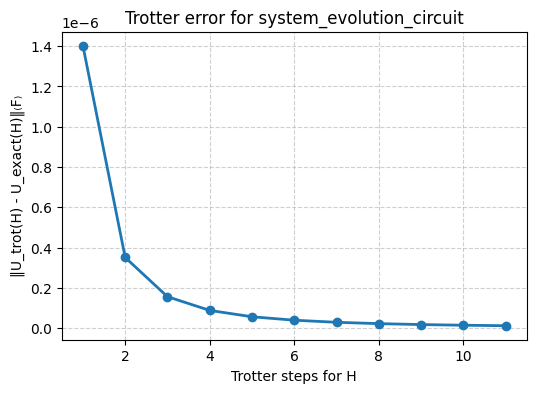

  → chosen trotter_steps_H for LiH: 4


KeyboardInterrupt: 

In [ ]:
from pyscf import gto, scf, mcscf
from google.colab import files
import json
import numpy as np
import cirq

# -----------------------------------------------------------
# 1) List of geometries (in Å)
#    You can add/remove molecules here.
# -----------------------------------------------------------
geometries = {
"LiH": "Li 0.0 0.0 0.0; H 0.0 0.0 1.5949",
}


trotter_target = 1e-7
trotter_steps_summary = {}

# -----------------------------------------------------------
# 2) Loop over geometries
# -----------------------------------------------------------
for name, atom_str in geometries.items():
    print(f"\n==============================")
    print(f"Processing molecule: {name}")
    print(f"Geometry: {atom_str}")

    # --- Build PySCF molecule (same logic as your LiH code) ---
    mol = gto.M(
        atom=atom_str,
        unit='Angstrom',
        basis='sto-3g',
        symmetry=0,
    )

    # ROHF then RHF (same as your code)
    mf = scf.ROHF(mol)
    mf.kernel()

    myhf = scf.RHF(mol)
    myhf.kernel()

    # Active space: no=2 spatial orbitals, ne=2 electrons (same as your code)
    no, ne = 2, 2
    mycas = mcscf.CASCI(myhf, no, ne)

    # ---- Pick HOMO & LUMO automatically, in a way that works for any molecule ----
    nmo = myhf.mo_coeff.shape[1]

    # find highest occupied MO (HOMO) in 0-based indexing
    occ_inds = np.where(myhf.mo_occ > 0)[0]
    homo = int(occ_inds[-1])  # last occupied

    # choose lumo as next orbital if exists, otherwise just use homo again
    lumo = homo + 1 if homo + 1 < nmo else homo

    # PySCF sort_mo expects 1-based indices
    cas_indices_1based = [homo + 1, lumo + 1]
    mo = mycas.sort_mo(cas_indices_1based)

    mycas.kernel(mo)

    # --- Build qubit Hamiltonian and PauliSum ---
    H_qubit = get_molecular_hamiltonian(mycas)
    n_system = int(np.log2(H_qubit.shape[0]))

    ancilla = cirq.LineQubit(0)
    system_qubits = [cirq.LineQubit(i) for i in range(1, n_system + 1)]

    H_pauli = csr_to_paulisum(H_qubit, system_qubits)

    # --- Compute w_max and Fourier coefficients c_k (same algorithm) ---
    H_mat = pauli_sum_matrix(H_pauli, system_qubits)
    E, V = np.linalg.eigh(H_mat)
    wmax = 2 * np.linalg.norm(H_mat, ord=2)
    _, cvals, _ = step_spikes_period_2L(wmax, 1000, A=1.0, window=None)

    # -------------------------------------------------------
    # 3) Find Trotter steps such that error < 1e-5
    # -------------------------------------------------------
    tau_s = 0.1  # same τ_s you used in trotter_error_vs_steps_H
    steps_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

    print("  Computing Trotter error vs steps...")
    steps_H, errors_H = trotter_error_vs_steps_H(
        H_pauli=H_pauli,
        system_qubits=system_qubits,
        tau_s=tau_s,
        order_H=2,
        steps_list=steps_list,
    )

    best_steps = None
    for s, e in zip(steps_H, errors_H):
        if e < trotter_target:
            best_steps = s
            break

    if best_steps is None:
        best_steps = steps_H[-1]  # fall back to largest if never below target

    trotter_steps_summary[name] = best_steps
    print(f"  → chosen trotter_steps_H for {name}: {best_steps}")

    # -------------------------------------------------------
    # 4) Build W circuit for this molecule with that step
    # -------------------------------------------------------
    tau_k = 0.2
    magnitudes = np.abs(np.imag(cvals))
    thetas = (np.sqrt(tau_k) / 2.0) * magnitudes  # same formula as your code

    # Same pairs / weights / layers / reps as your snippet
    pairs   = [(0, 2), (1, 3), (0, 3)]
    weights = [0.5, 0.3, 0.2]
    n_layers   = 1
    reps_per_W = 1000

    W_circ, chosen_pairs = build_random_W_stack(
        ancilla=ancilla,
        system_qubits=system_qubits,
        H_pauli=H_pauli,   # this molecule's Hamiltonian
        tau_s=tau_k,
        thetas=thetas,
        pairs=pairs,
        weights=weights,
        n_layers=n_layers,
        reps_per_W=reps_per_W,
        order_H=1,
        trotter_steps_H=best_steps,   # <--- molecule-specific!
        seed=123,
    )

    print("  Chosen pairs per W layer:", chosen_pairs)

    # -------------------------------------------------------
    # 5) Save & download JSON for THIS molecule
    # -------------------------------------------------------
    filename = f"W_{name}.json"
    cirq.to_json(W_circ, filename)
    print(f"  Saved JSON to {filename}")
    files.download(filename)

# -----------------------------------------------------------
# 6) Save a JSON summary of the chosen Trotter steps
# -----------------------------------------------------------
with open("trotter_steps_summary.json", "w") as f:
    json.dump(trotter_steps_summary, f, indent=2)

print("\nSummary of chosen Trotter steps:")
for name, steps in trotter_steps_summary.items():
    print(f"  {name}: {steps}")

files.download("trotter_steps_summary.json")
